# Scalp EEG

The scalp electroencephalogram (scalp EEG) is a non-invasive measure of the electrical potentials generated by the activity of tens of millions of neurons within the brain. The arrangement of the electrodes on the scalp is done in a specific manner which is an international standard called "10-20 system". The electrode then detects neuronal electrical activity from under the scalp by measuring the potential difference at two electrodes, which then forms a channel. For instance, the channel FP1 - F7 is the potential difference measured at electrodes FP1 and F7. It should be noted that signal from deep brain region can be attenuated before reaching electrodes on the scalp, thus activity from this area is usually unobservable.

<img src="http://www.bem.fi/book/13/13x/1302cx.gif" width="300" height="300" />

## Epileptic Seizures

There are two types of epileptic seizures: focal and generalised.

Focal seizures are localised, meaning it starts from a specific region in the brain. Focal seizures can spread to adjacent brain areas and eventually to the entire brain.

Generalised seizures occur throughout the cerebral cortex region. A lateral view of the cortex is shown below which highlights various cortical regions.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/33/Human_motor_cortex.jpg" width="300" height="300" />

## EEG Activity

EEG activity is viewed in terms of spatial distribution and dominant frequency component. The spacial distribution is concerned with which area of the scalp region a signal originates from. Dominant frequency component, are 5 frequency bands which have known brain states associated with them. Electrial voltages from the brain are measured through EEG and the unit of measurement is $\mu V$. Different regions of the brain do not emit the same frequency at the same time, therefore, EEG signal measured by electrodes on the scalp will consist of many waves with different characteristics. Further, as each frequency band pattern could be different for every patient, interpretation just by looking at raw signal is difficult.

![Brain waves](https://ars.els-cdn.com/content/image/3-s2.0-B9780128044902000026-f02-01-9780128044902.jpg)

Source: [ScienceDirect](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/brain-waves)

In [4]:
import re
import mne
import yasa
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# %matplotlib osx

In [6]:
fpath = '/Users/Ilyess/Desktop/physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf'
raw = mne.io.read_raw_edf(input_fname=fpath)
raw

Extracting EDF parameters from /Users/Ilyess/Desktop/physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/sq/1d9vw_p93hddr01jrtg60wdr0000gp/T/ipykernel_60965/3754854629.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(input_fname=fpath)


<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~27 KiB, data not loaded>

## Montage

The electrodes in this dataset has been placed using the 10-20 system as mentioned earlier. It is an internationally recognised method that allows EEG electrode placement to be standardised. It also ensures inter-electrode spacing is equal and that electrode placements are proportional to the patient's skull size and shape. The brain regions covered are coded by the following letters:

- F: Frontal
- P: Parietial
- T: Temporal
- O: Occipital

Each electrode name will have a letter followed by a number. The letter will designate of the the corresponding brain region and the number will designate whether the electrode is on the left or right. If instead of a number, the value is 'z', it corresponds to the midline. Refer to the diagram below for clarity.

- Odd number: left side
- Even number: right side
- Z: midline (nose to rear of head)

<img src="attachment:f8680855-26b3-4745-afa5-90ead2a00cf8.png" width="300" height="300" />
<img src="https://www.fieldtriptoolbox.org/assets/img/template/layout/easycapm25.png" width="300" height="300" />

Source: [ERS Workshop](https://www.ers-education.org/lrmedia/2016/pdf/298830.pdf)

In [7]:
replace_dict = {}
drop_list = []
# for the channel names in the data...
for channel_name in raw.info['ch_names']:
    # get the name to change too
    name_change = re.findall('\w+',channel_name)[0].title()
    # check if it is already in the change list
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        # if its not already there get the origional name and what we want to 
        # change it to
        replace_dict[channel_name] = name_change

# drop the ones that would be repeats
raw.drop_channels(drop_list)
# rename the channels
raw.rename_channels(replace_dict)
# set the standard montage
montage =  mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False)

<RawEDF | chb01_03.edf, 18 x 921600 (3600.0 s), ~31 KiB, data not loaded>

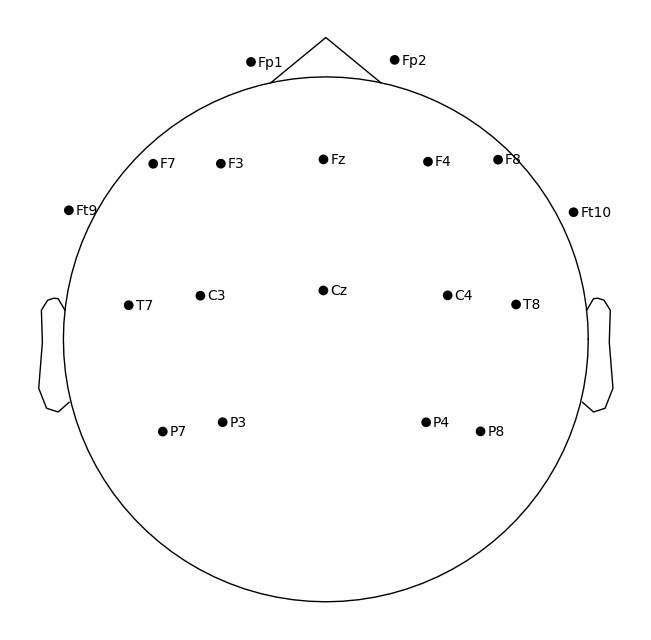

In [8]:
_ = raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True)

Dates in the original .edf files have been replaced by surrogate dates, but the time relationships between the individual files belonging to each case have been preserved. In most cases, the .edf files contain exactly one hour of digitized EEG signals.

In [9]:
# annotate seizure data
seizure_start = 2996 # in seconds
seizure_end = 3036
seizure_duration = seizure_end - seizure_start
annotation = mne.Annotations(onset=[0, seizure_start, seizure_end], 
                             duration=[seizure_start, seizure_duration, ((60*59)-seizure_end)], 
                             description=['Background', 'Seizure', 'Background'])
raw.set_annotations(annotation)
raw.annotations

<Annotations | 3 segments: Background (2), Seizure (1)>

## Band Power

If we observe the band power in each channel before, during and after a seizure, we can learn more about which frequency band dominates during a seizure. The main bands we are interested in are:
- Delta: $f   < 4$ Hz
- Theta: $4 < f < 8 $ Hz
- Alpha: $8 < f < 12$ Hz
- Beta:  $12 < f < 30$ Hz
- Gamma: $30 < f < 200$ Hz

Source: [Analysis of Gamma-Band Activity from Human EEG Using Empirical Mode Decomposition, C. Amo et al., 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5469342/)

In [10]:
selected_bands = [(1, 4, 'Delta'),
         (4, 8, 'Theta'),
         (8, 12, 'Alpha'),
         (12, 30, 'Beta'),
         (30, 127,'Gamma')] # Nyquest frequency is 128 Hz for 256 Hz samping rate, thus we can only see up to 127 Hz limit.

## Background EEG

The data has annotations made by a clinician which marks out the seizure times. Therefore, to see the background EEG signal, we will plot some data outside of this marked seizure time.

In [11]:
# plot parameters
plot_kwargs = {
    'scalings': dict(eeg=25e-5),   # zooms the plot out
    'show_scrollbars': False,
    'show': True
}

Using matplotlib as 2D backend.


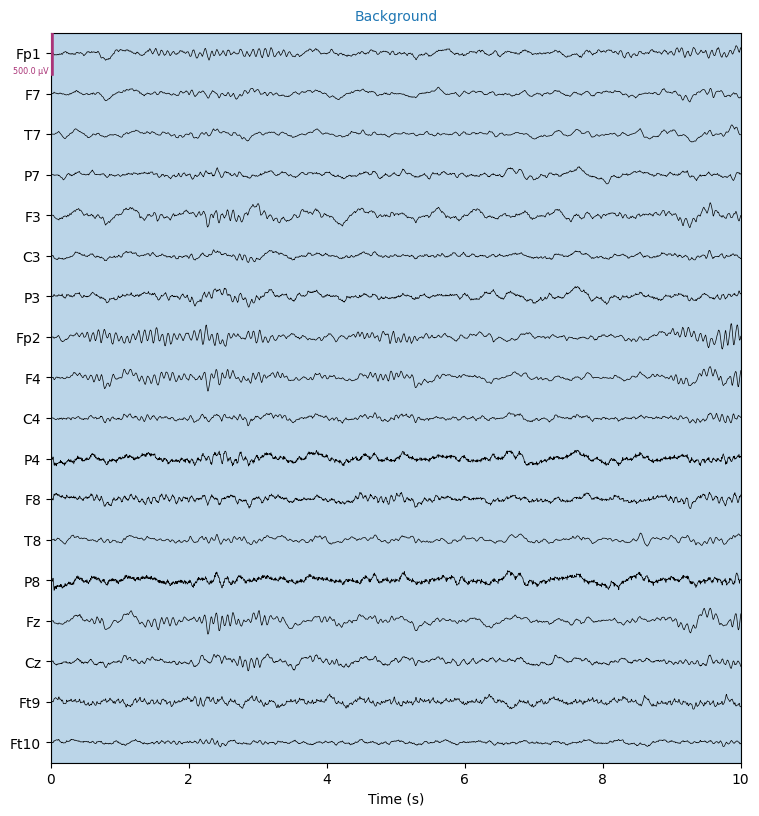

In [12]:
_ = raw.plot(start=0, duration=10, **plot_kwargs) # 10s preview

(18, 10240)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


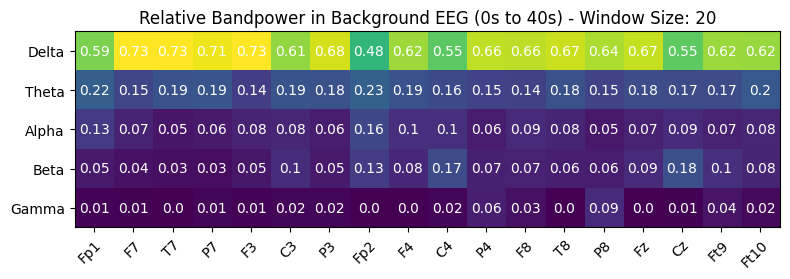

In [13]:
# determine the dominant brain wave in all channels background period
window_size = 20
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([0, 40])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, start_sample:stop_sample]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)
df.iloc[:,0:6]

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Background EEG (0s to 40s) - Window Size: {window_size}')
fig.tight_layout()
plt.show()

High levels of delta power would indicate subject chb_001 was sleeping before the seizure started.

## Seizure EEG

We observe that in the seizure period, the signal shifts to a higher frequency.

In [14]:
# plot parameters
plot_kwargs = {
    'scalings': dict(eeg=25e-5),   # zooms the plot out
    'show_scrollbars': False,
    'show': True
}

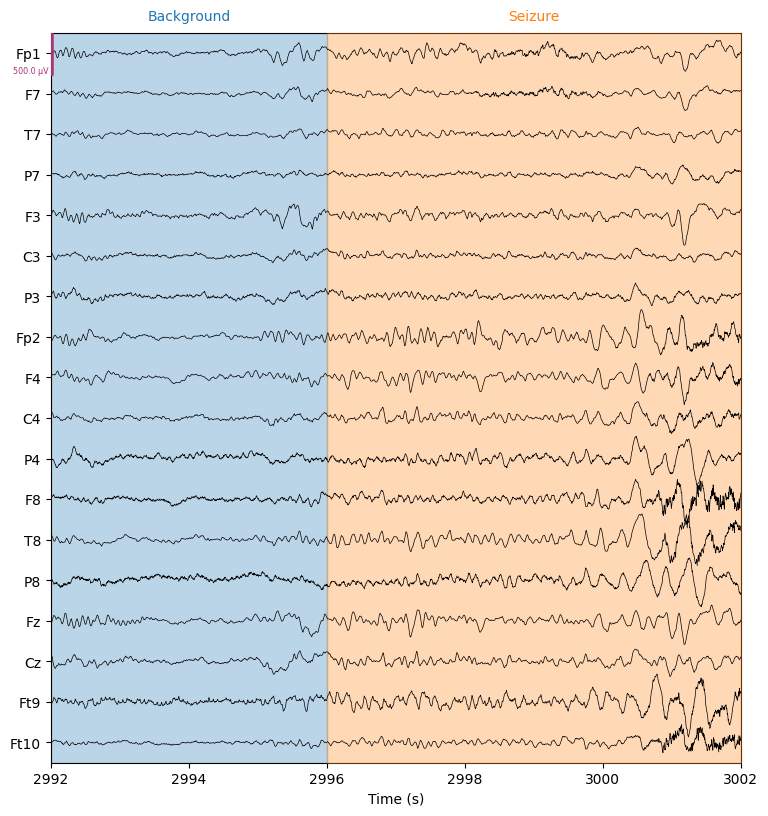

In [15]:
_ = raw.plot(start=seizure_start-4, duration=10, **plot_kwargs) # 4s before seizure start

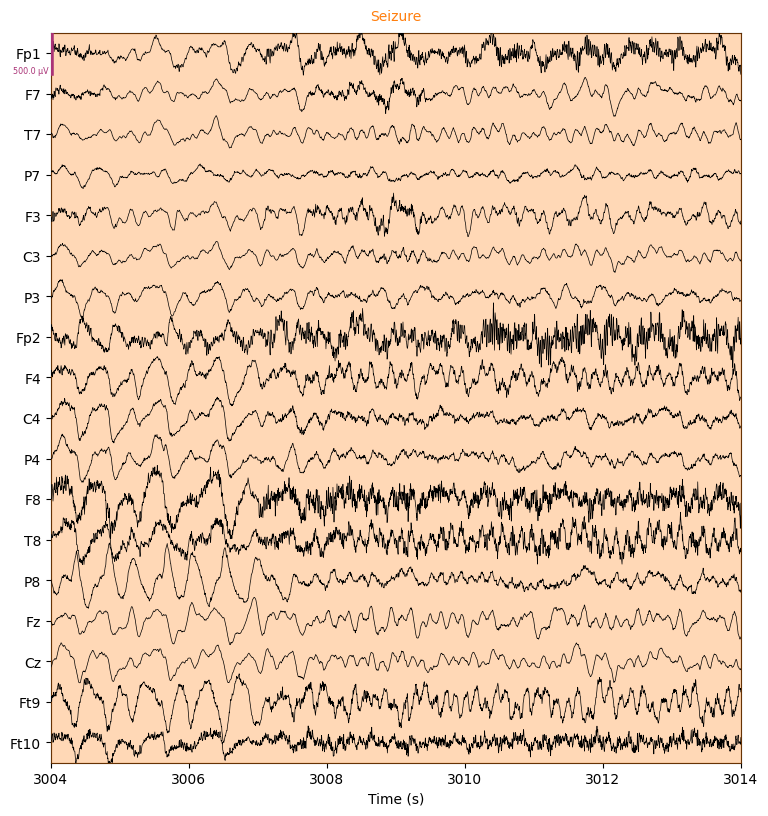

In [16]:
_ = raw.plot(start=seizure_start+8, duration=10, **plot_kwargs) # continued from above...

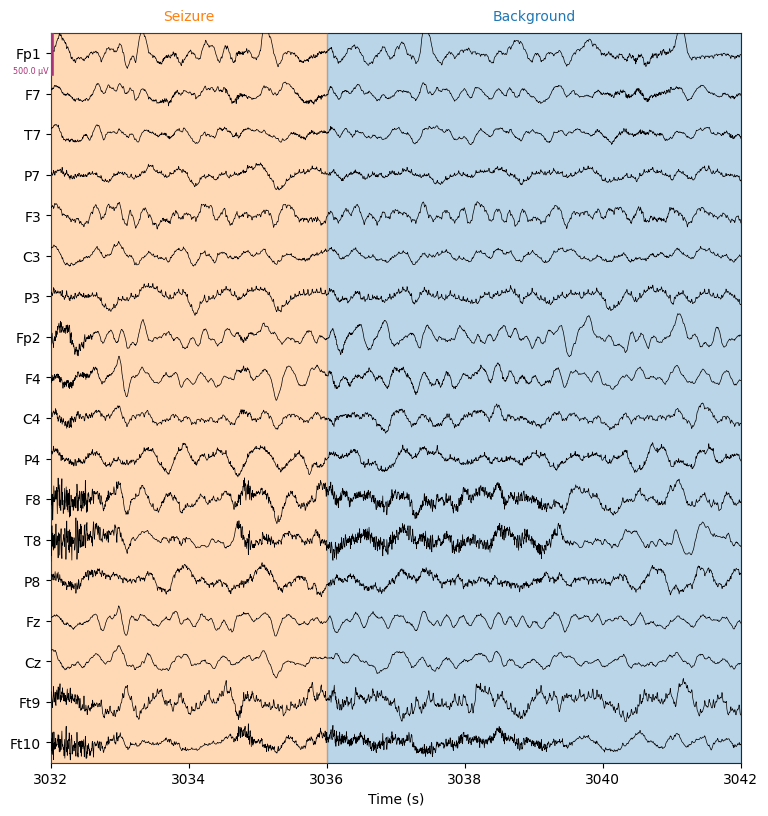

In [17]:
_ = raw.plot(start=seizure_end-4, duration=10, **plot_kwargs) # last 10s into the seizure

(18, 10240)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


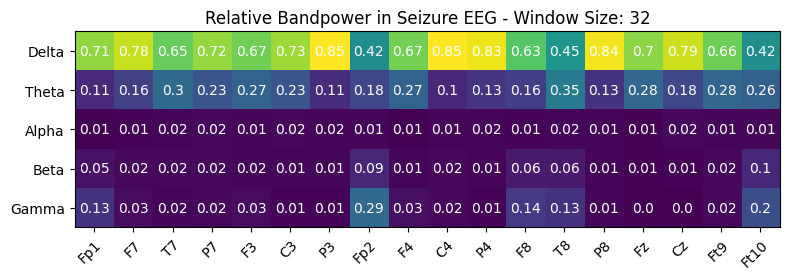

In [18]:
# determine the dominant brain wave in all channels from seizure period
window_size = 32
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([seizure_start, seizure_end])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, start_sample:stop_sample]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)
df.iloc[:,0:6]

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()